# Séance 3 GeoPandas | Analyse spatiale

# Initialisation de l'environnement de travail

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install geopandas
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Install scalebar
!pip install matplotlib_scalebar

In [ ]:
#Importation des librairies nécessaires
from shapely.geometry import LineString, Point, Polygon
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
import numpy as np
from pprint import pprint
import pygeos
from matplotlib_scalebar.scalebar import ScaleBar #Echelle cartographique

# Import et préparation des données

In [ ]:
#Téléchargement des datas depuis le site opendata de Paris
!wget -O velibs.geojson https://opendata.paris.fr/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr
!wget -O IRIS.geojson https://data.iledefrance.fr/explore/dataset/iris/download/?format=geojson&refine.dep=75&timezone=Europe/Berlin&lang=fr 
!wget -O pistescyclables.geojson https://opendata.paris.fr/explore/dataset/reseau-cyclable/download/?format=geojson&timezone=Europe/Berlin&lang=fr

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,"POLYGON ((651827.000 6860330.000, 651871.600 6..."
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,"POLYGON ((648699.720 6861458.710, 648626.610 6..."
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,"POLYGON ((650095.100 6864047.000, 650096.000 6..."
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,"POLYGON ((654660.400 6862417.100, 654717.000 6..."
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,"POLYGON ((654009.750 6863582.110, 654007.750 6..."


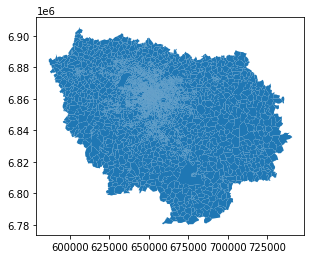

In [ ]:
#Importer et reprojeter la couche des IRIS
IRIS= gpd.read_file("IRIS.geojson", encoding='utf-8')
IRIS = IRIS.to_crs(2154)
IRIS.plot()
IRIS.head()

<Axes: >

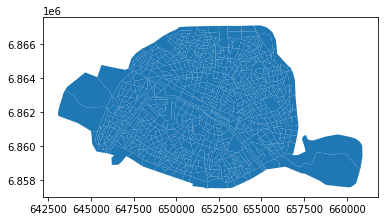

In [ ]:
#Garder que les IRIS de Paris  
IRIS = IRIS[(IRIS["dep"] == 75)]
IRIS.plot()

<Axes: >

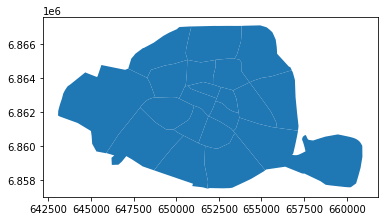

In [ ]:
# Créer une couche des arrondissements
ARDT = IRIS.dissolve(by='nom_com')
ARDT.plot()

,name,stationcode,ebike,mechanical,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning,geometry
0,Benjamin Godard - Victor Hugo,16107,13,6,2023-03-24 12:32:18+00:00,19,15,35,OUI,OUI,Paris,OUI,POINT (646867.548 6863127.314)
1,Mairie de Rosny-sous-Bois,31104,4,3,2023-03-24 12:31:46+00:00,7,22,30,OUI,OUI,Rosny-sous-Bois,OUI,POINT (662339.371 6863592.468)
2,Toudouze - Clauzel,9020,1,0,2023-03-24 12:26:47+00:00,1,20,21,OUI,OUI,Paris,OUI,POINT (651401.378 6864567.904)


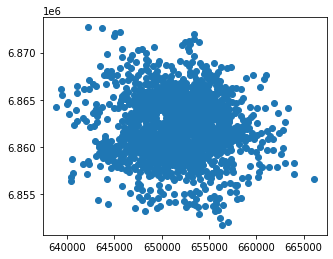

In [ ]:
#Importer et reprojeter la couche des velibs
Velibs= gpd.read_file("velibs.geojson", encoding='utf-8')
Velibs = Velibs.to_crs(2154)
Velibs.plot()
Velibs.head(3)

#### Traitement spatial

[Overlay Documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.overlay.html#geopandas.GeoDataFrame.overlay)

[Clip Documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.clip.html)

[SJoin Nearest Documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin_nearest.html)

995

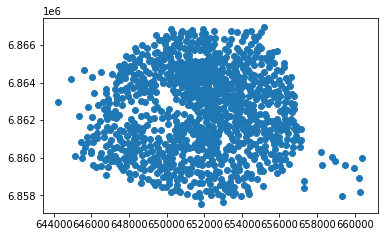

In [ ]:
#Ne garder que les stations de Velibs de la ville de Paris (sélection par localisation)
VelibParis = gpd.overlay(Velibs, ARDT, how='intersection') #Extrait les données qui intersecte avec la couche arrondissement
VelibParis.plot() #Couche A dans l'overlay donne la table attributaire
VelibParis['name'].size

In [ ]:
#Regarder la table attributaire
VelibParis.head()

,name,stationcode,ebike,mechanical,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning,nom_iris,insee_com,iris,typ_iris,code_iris,dep,geometry
0,Benjamin Godard - Victor Hugo,16107,13,6,2023-03-24 12:32:18+00:00,19,15,35,OUI,OUI,Paris,OUI,Auteuil 3,75116,6103,H,751166103,75,POINT (646867.548 6863127.314)
1,Saint-Cloud - Hippodrome,16138,4,2,2023-03-24 12:26:52+00:00,6,22,30,OUI,OUI,Paris,OUI,Auteuil 3,75116,6103,H,751166103,75,POINT (645332.019 6862222.918)
2,Michel-Ange - Parent de Rosan,16118,0,6,2023-03-24 12:31:27+00:00,6,18,26,OUI,OUI,Paris,OUI,Auteuil 3,75116,6103,H,751166103,75,POINT (645570.979 6860314.540)
3,Marceau - Chaillot,8048,10,3,2023-03-24 12:29:08+00:00,13,5,21,OUI,OUI,Paris,OUI,Auteuil 3,75116,6103,H,751166103,75,POINT (648548.643 6863429.173)
4,Octave Feuillet - Albéric Magnard,16110,2,0,2023-03-24 12:26:57+00:00,2,18,21,OUI,OUI,Paris,OUI,Auteuil 3,75116,6103,H,751166103,75,POINT (646664.695 6862582.742)


ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



,circulation,length,date_de_livraison,bois,couloir_bus,typologie_simple,statut,sens_velo,bidirectionnel,longueur_du_troncon_en_km,voie,arrdt,piste,type_continuite,reseau,position,geometry
0,NaN,5.955384,2013-12-31,Non,NaN,Bandes cyclables,VOIE 50,CONTRESENS,Non,0.005955,AVENUE FELIX FAURE,15.0,NaN,NaN,NaN,NaN,"LINESTRING (647320.129 6860108.864, 647322.172..."
1,NaN,142.714717,2010-06-10,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.142715,RUE CIVIALE,10.0,NaN,NaN,NaN,NaN,"LINESTRING (654137.796 6863870.485, 654189.364..."
2,NaN,98.520279,2010-12-31,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.098520,RUE D OUESSANT,15.0,NaN,NaN,NaN,NaN,"LINESTRING (648514.230 6861290.908, 648473.072..."


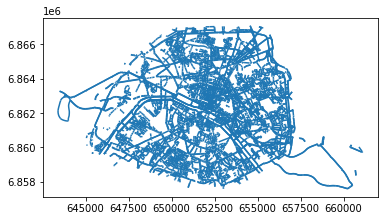

In [ ]:
#Importer la couche des pistes cyclables
pistescyclables= gpd.read_file("pistescyclables.geojson", encoding='utf-8')
pistescyclables = pistescyclables.to_crs(2154)
pistescyclables.plot()
pistescyclables.head(3)

# Opérateurs métriques 

Calcul de surface, de longueur

In [ ]:
#Calculer la surface des IRIS (en km2) 
IRIS["surface"] = IRIS['geometry'].area/1000000
IRIS["surface"] = IRIS["surface"].round(3)
IRIS.head(5)

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,"POLYGON ((651827.000 6860330.000, 651871.600 6...",0.123
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,"POLYGON ((648699.720 6861458.710, 648626.610 6...",0.124
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,"POLYGON ((650095.100 6864047.000, 650096.000 6...",0.080
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,"POLYGON ((654660.400 6862417.100, 654717.000 6...",0.051
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,"POLYGON ((654009.750 6863582.110, 654007.750 6...",0.035


In [ ]:
#Calculer la longueur (en metre) des tronçons des pistes cyclables
pistescyclables["longueur"] = pistescyclables['geometry'].length
pistescyclables['longueur'] = pistescyclables['longueur'].round(0)
pistescyclables.head(3)

,circulation,length,date_de_livraison,bois,couloir_bus,typologie_simple,statut,sens_velo,bidirectionnel,longueur_du_troncon_en_km,voie,arrdt,piste,type_continuite,reseau,position,geometry,longueur
0,NaN,5.955384,2013-12-31,Non,NaN,Bandes cyclables,VOIE 50,CONTRESENS,Non,0.005955,AVENUE FELIX FAURE,15.0,NaN,NaN,NaN,NaN,"LINESTRING (647320.129 6860108.864, 647322.172...",6.0
1,NaN,142.714717,2010-06-10,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.142715,RUE CIVIALE,10.0,NaN,NaN,NaN,NaN,"LINESTRING (654137.796 6863870.485, 654189.364...",143.0
2,NaN,98.520279,2010-12-31,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.098520,RUE D OUESSANT,15.0,NaN,NaN,NaN,NaN,"LINESTRING (648514.230 6861290.908, 648473.072...",99.0


# Transformations géométriques

* Polygone to point : centroid
* Polygone to line : boundary
* Point to polygone : polygone de voronoi
* Point to line : ...

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,POINT (652014.243 6860487.692),0.123
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,POINT (648386.749 6861844.476),0.124
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,POINT (649825.004 6863921.860),0.080
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,POINT (654612.063 6862260.944),0.051
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,POINT (654014.821 6863422.485),0.035


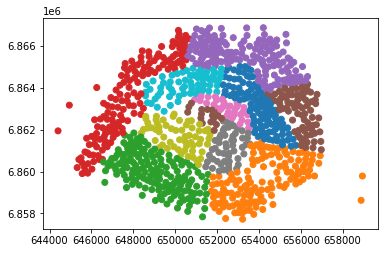

In [ ]:
#Créer une couche de centroides des IRIS
IRIScentro = IRIS.copy()#Créer une copie de la couche IRIS
IRIScentro.geometry = IRIScentro['geometry'].centroid
IRIScentro.plot(column = "nom_com")
IRIScentro.head()

In [ ]:
# Créer une paire de coordonées géographique en WGS84 pour la couche des IRIS sans créer de couche centroid en plus (en 2154)
IRIS["Longitude"] = IRIS['geometry'].centroid.to_crs(4326).x.round(4)
IRIS["Latitude"] = IRIS['geometry'].centroid.to_crs(4326).y.round(4)
IRIS.head()

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface,Longitude,Latitude
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,"POLYGON ((651827.000 6860330.000, 651871.600 6...",0.123,2.3462,48.8426
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,"POLYGON ((648699.720 6861458.710, 648626.610 6...",0.124,2.2966,48.8546
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,"POLYGON ((650095.100 6864047.000, 650096.000 6...",0.080,2.3159,48.8734
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,"POLYGON ((654660.400 6862417.100, 654717.000 6...",0.051,2.3814,48.8588
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,"POLYGON ((654009.750 6863582.110, 654007.750 6...",0.035,2.3731,48.8692


In [ ]:
# Créer une paire de coordonées géographique en WGS84 pour la couche des IRIS (en 2154)
IRIScentro["Longitude"] = IRIScentro['geometry'].to_crs(4326).x
IRIScentro["Latitude"] = IRIScentro['geometry'].to_crs(4326).y
IRIScentro.head()

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface,Longitude,Latitude
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,POINT (652014.243 6860487.692),0.123,2.346177,48.842649
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,POINT (648386.749 6861844.476),0.124,2.296589,48.854570
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,POINT (649825.004 6863921.860),0.080,2.315944,48.873365
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,POINT (654612.063 6862260.944),0.051,2.381382,48.858784
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,POINT (654014.821 6863422.485),0.035,2.373117,48.869187


<Axes: >

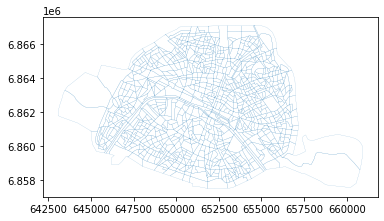

In [ ]:
# Créer une couche de contours des IRIS
IRISContours = IRIS.boundary
IRISContours.plot(linewidth=0.1)

# Jointure spatiale et agrégation statistique

In [ ]:
# Jointure spatiale Velibs <> IRIS
Velibok = gpd.sjoin(VelibParis, IRIS)
Velibok.head()

,name,stationcode,ebike,mechanical,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,...,nom_iris_right,insee_com_right,iris_right,typ_iris_right,code_iris_right,nom_com,dep_right,surface,Longitude,Latitude
0,Benjamin Godard - Victor Hugo,16107,13,6,2023-03-24 12:32:18+00:00,19,15,35,OUI,OUI,...,Porte Dauphine 4,75116,6304,H,751166304,Paris 16e Arrondissement,75,0.105,2.2744,48.8662
16,Flandrin - Henri Martin,16018,7,5,2023-03-24 12:32:11+00:00,12,4,18,OUI,OUI,...,Porte Dauphine 4,75116,6304,H,751166304,Paris 16e Arrondissement,75,0.105,2.2744,48.8662
1,Saint-Cloud - Hippodrome,16138,4,2,2023-03-24 12:26:52+00:00,6,22,30,OUI,OUI,...,Bois de Boulogne,75116,6177,D,751166177,Paris 16e Arrondissement,75,3.433,2.2423,48.8552
2,Michel-Ange - Parent de Rosan,16118,0,6,2023-03-24 12:31:27+00:00,6,18,26,OUI,OUI,...,Auteuil 5,75116,6105,H,751166105,Paris 16e Arrondissement,75,0.082,2.2596,48.8399
3,Marceau - Chaillot,8048,10,3,2023-03-24 12:29:08+00:00,13,5,21,OUI,OUI,...,Chaillot 2,75116,6402,H,751166402,Paris 16e Arrondissement,75,0.136,2.2956,48.8673


In [ ]:
#Réorganiser la table et renommer les colonnes
Velibok = Velibok[["stationcode", "name", "capacity", "numbikesavailable", "numdocksavailable", "nom_com", "nom_iris_right", "code_iris_right", "geometry"]]
Velibok = Velibok.rename(columns={'Code_Station': 'ID_Station', 'name':'Nom', 'capacity':'Capacite', 'numbikesavailable': 'nbVelos','numdocksavailable': 'Nbemplacements', 'nom_com': 'Arrondissement', 'nom_iris_right':'IRIS', 'code_iris_right':'CodeIRIS'})
Velibok.head()

,stationcode,Nom,Capacite,nbVelos,Nbemplacements,Arrondissement,IRIS,CodeIRIS,geometry
0,16107,Benjamin Godard - Victor Hugo,35,19,15,Paris 16e Arrondissement,Porte Dauphine 4,751166304,POINT (646867.548 6863127.314)
16,16018,Flandrin - Henri Martin,18,12,4,Paris 16e Arrondissement,Porte Dauphine 4,751166304,POINT (646623.214 6862945.467)
1,16138,Saint-Cloud - Hippodrome,30,6,22,Paris 16e Arrondissement,Bois de Boulogne,751166177,POINT (645332.019 6862222.918)
2,16118,Michel-Ange - Parent de Rosan,26,6,18,Paris 16e Arrondissement,Auteuil 5,751166105,POINT (645570.979 6860314.540)
3,8048,Marceau - Chaillot,21,13,5,Paris 16e Arrondissement,Chaillot 2,751166402,POINT (648548.643 6863429.173)


In [ ]:
# Ajouter une colonne avec le tx d'occupation de chaque stations dans la table des stations
Velibok["Txoccupation"] = (Velibok["Capacite"]-Velibok["Nbemplacements"]) / Velibok["Capacite"] *100
Velibok["Txoccupation"] = Velibok["Txoccupation"].round(1)
Velibok.head()

,stationcode,Nom,Capacite,nbVelos,Nbemplacements,Arrondissement,IRIS,CodeIRIS,geometry,Txoccupation
0,16107,Benjamin Godard - Victor Hugo,35,19,15,Paris 16e Arrondissement,Porte Dauphine 4,751166304,POINT (646867.548 6863127.314),57.1
16,16018,Flandrin - Henri Martin,18,12,4,Paris 16e Arrondissement,Porte Dauphine 4,751166304,POINT (646623.214 6862945.467),77.8
1,16138,Saint-Cloud - Hippodrome,30,6,22,Paris 16e Arrondissement,Bois de Boulogne,751166177,POINT (645332.019 6862222.918),26.7
2,16118,Michel-Ange - Parent de Rosan,26,6,18,Paris 16e Arrondissement,Auteuil 5,751166105,POINT (645570.979 6860314.540),30.8
3,8048,Marceau - Chaillot,21,13,5,Paris 16e Arrondissement,Chaillot 2,751166402,POINT (648548.643 6863429.173),76.2


<Axes: xlabel='Capacite', ylabel='nbVelos'>

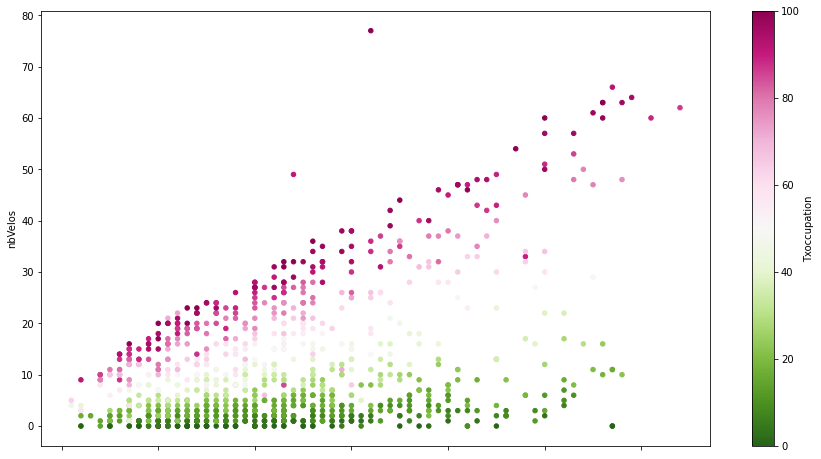

In [ ]:
# Explorer les données avec un nuage de points

Velibok.plot(figsize =(15,8), kind="scatter", x="Capacite", y= "nbVelos", c= "Txoccupation", cmap='PiYG_r')

<Axes: >

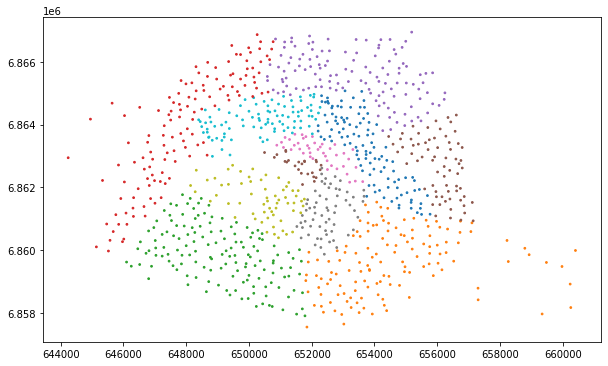

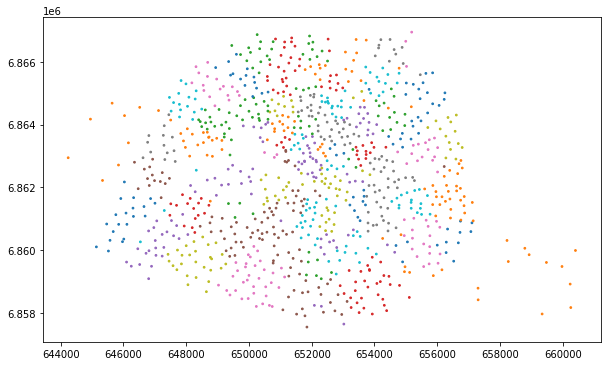

In [ ]:
#Faire deux cartes (stations catégorisées par Arrondissement et par IRIS) pour vérification

Velibok.plot(figsize=(10,10),column='Arrondissement', markersize= 3, legend=False)
Velibok.plot(figsize=(10,10),column='IRIS', markersize=3,  legend=False)

In [ ]:
# Compter le nombre de stations de vélibs par arrondissement dans un dataframe
NbvelibArdt  = Velibok[["Arrondissement", "stationcode"]].groupby("Arrondissement").size() #.size pour le count
NbvelibArdt =pd.DataFrame(NbvelibArdt) #Passage en dataframe pour enlever la carto
NbvelibArdt = NbvelibArdt.rename(columns={0: 'Nbstations'}) #Renomme la colonne sinon pas de nom
NbvelibArdt.head(5)

,Nbstations
Arrondissement,
Paris 10e Arrondissement,54
Paris 11e Arrondissement,56
Paris 12e Arrondissement,68
Paris 13e Arrondissement,67
Paris 14e Arrondissement,56


<Axes: xlabel='Arrondissement'>

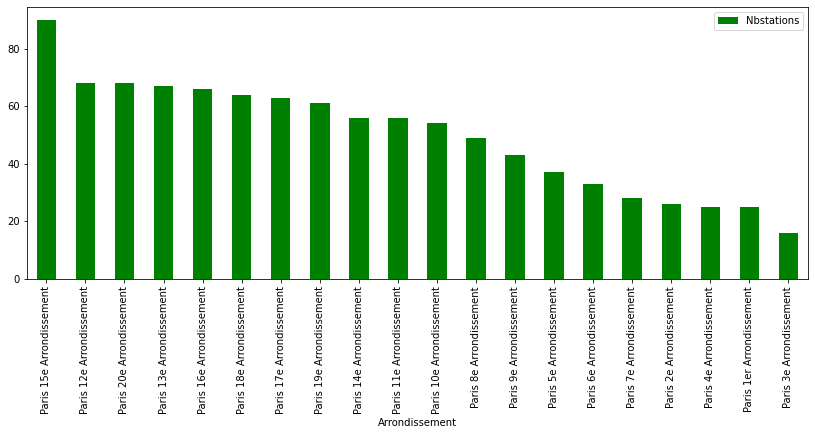

In [ ]:
# faire un graphique pour visualiser le nb de stations de vélibs par arrondissement (descendant)
NbvelibArdt = NbvelibArdt.sort_values("Nbstations", ascending=False)
NbvelibArdt.plot(figsize =(14,5), kind="bar", color = "green")

In [ ]:
#Vérification somme tjr vérifier lors d'une agrégation ou désagrégation le nb d'individus car possibilités de pertes ou créations

A = VelibParis['stationcode'].count()
B = NbvelibArdt['Nbstations'].sum()

print ("Nb stations vélibs départ = " + str(A) + "\nNb stations vélibs ardt = " + str(B) )

Nb stations vélibs départ = 995
Nb stations vélibs ardt = 995


In [ ]:
# Compter le nombre de stations de vélibs par IRIS dans un dataframe
NbvelibIRIS  = Velibok[["IRIS", "stationcode"]].groupby("IRIS").size()
NbvelibIRIS =pd.DataFrame(NbvelibIRIS)
NbvelibIRIS = NbvelibIRIS.rename(columns={0: 'Nbstations'})
NbvelibIRIS.head(5)

,Nbstations
IRIS,
Amerique 11,1
Amerique 13,1
Amerique 14,1
Amerique 18,1
Amerique 19,4


<Axes: xlabel='Arrondissement'>

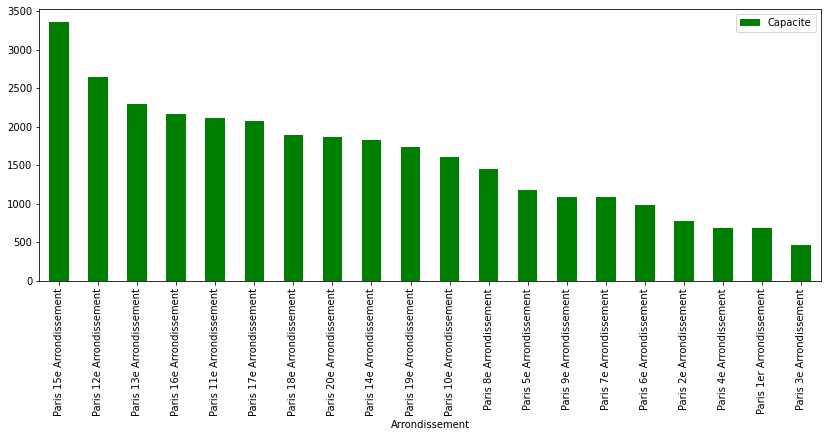

In [ ]:
# Calculer la capacité des stations de vélibs par arrondissement et faire un graphique (résumé statistique)

NbvelibArdt  = Velibok[["Arrondissement", "Capacite"]].groupby("Arrondissement").sum()
NbvelibArdt =pd.DataFrame(NbvelibArdt)
NbvelibArdt = NbvelibArdt.rename(columns={0: 'Nbstations'})
NbvelibArdt.head(5)


NbvelibArdt = NbvelibArdt.sort_values("Capacite", ascending=False)
NbvelibArdt.plot(figsize =(14,5), kind="bar", color = "green")

In [ ]:
# Calculer la capacité des stations de vélibs par IRIS 

NbvelibIRIS  = Velibok[["IRIS", "Capacite"]].groupby("IRIS").sum()
NbvelibIRIS =pd.DataFrame(NbvelibIRIS)
NbvelibIRIS.head(5)

,Capacite
IRIS,
Amerique 11,28
Amerique 13,18
Amerique 14,17
Amerique 18,17
Amerique 19,94


<Axes: ylabel='Frequency'>

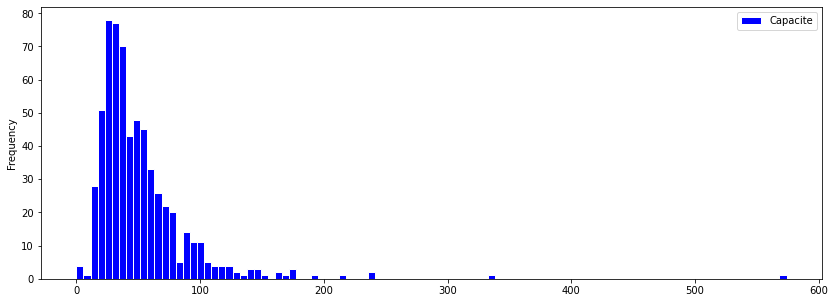

In [ ]:
# Faire un histogramme de cette nouvelle variable

NbvelibIRIS.plot(figsize =(14,5), kind="hist", bins = 100, color = "blue", edgecolor = 'white')

In [ ]:
#Sortir des statistiques descriptives

A = NbvelibIRIS['Capacite'].min()
B = NbvelibIRIS['Capacite'].max()
C = NbvelibIRIS['Capacite'].sum()
D = NbvelibIRIS['Capacite'].mean()

print ("Capacité minimale = " + str(A) + "\nCapacité maximale = " + str(B) + "\nCapacité totale = " + str(C) + "\nCapacité moyenne = " + str(D) )

Capacité minimale = 0
Capacité maximale = 574
Capacité totale = 31943
Capacité moyenne = 51.02715654952077


In [ ]:
# Calculer la capacité des stations de vélibs ET le taux moyen d'occupation par IRIS 

NbvelibIRIS  = Velibok[["IRIS", "Capacite", "Txoccupation"]].groupby("IRIS").agg(['sum', 'mean']) #Deux agrégations de 2 variales
NbvelibIRIS =pd.DataFrame(NbvelibIRIS)
NbvelibIRIS.head(5)

Capacite       Txoccupation           
                 sum  mean          sum       mean
IRIS                                              
Amerique 11       28  28.0         17.9  17.900000
Amerique 13       18  18.0          5.6   5.600000
Amerique 14       17  17.0         17.6  17.600000
Amerique 18       17  17.0         23.5  23.500000
Amerique 19       94  23.5         31.9  10.633333

In [ ]:
#Solution au pb de doubles lignes en entête de la double agrégations
# Calculer la capacité des stations de vélibs ET le taux moyen d'occupation par IRIS 

NbvelibIRIS  = Velibok[["IRIS", "Capacite"]].groupby("IRIS").sum()
NbvelibIRIS =pd.DataFrame(NbvelibIRIS)
NbvelibIRIS.head(5)

,Capacite
IRIS,
Amerique 11,28
Amerique 13,18
Amerique 14,17
Amerique 18,17
Amerique 19,94


In [ ]:
# Calculer la capacité des stations de vélibs ET le taux moyen d'occupation par IRIS 

TxoccvelibIRIS  = Velibok[["IRIS", "Txoccupation"]].groupby("IRIS").mean()
TxoccvelibIRIS =pd.DataFrame(TxoccvelibIRIS)
TxoccvelibIRIS.head(5)

,Txoccupation
IRIS,
Amerique 11,17.900000
Amerique 13,5.600000
Amerique 14,17.600000
Amerique 18,23.500000
Amerique 19,10.633333


In [ ]:
# Faire la jointure attributaire avec la couche des IRIS (Problème ???)

IRISOK = IRIS.merge(NbvelibIRIS, left_on='nom_iris', right_on='IRIS')
IRISFINAL = IRISOK.merge(TxoccvelibIRIS, left_on='nom_iris', right_on='IRIS')
IRISFINAL.head()

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface,Longitude,Latitude,Capacite,Txoccupation
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,"POLYGON ((651827.000 6860330.000, 651871.600 6...",0.123,2.3462,48.8426,24,91.70
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,"POLYGON ((648699.720 6861458.710, 648626.610 6...",0.124,2.2966,48.8546,56,57.00
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,"POLYGON ((650095.100 6864047.000, 650096.000 6...",0.080,2.3159,48.8734,72,90.25
3,Maison Blanche 3,75113,5103,H,751135103,Paris 13e Arrondissement,75,"POLYGON ((653157.000 6857882.000, 653092.000 6...",0.059,2.3601,48.8207,26,11.50
4,Vivienne 1,75102,601,H,751020601,Paris 2e Arrondissement,75,"POLYGON ((651298.400 6863179.800, 651280.900 6...",0.123,2.3389,48.8676,133,83.70


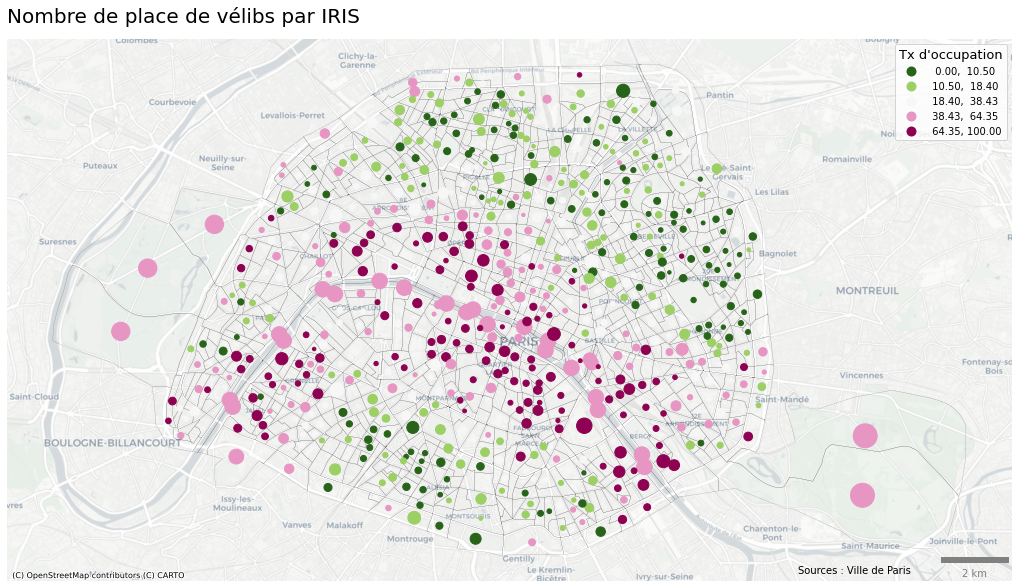

In [ ]:
#Cartographier la capacité (totale) et le taux d'utilisation (moyen) des stations de vélibs par IRIS

IRISFINAL.geometry = IRISFINAL['geometry'].centroid

Carte1, ax = plt.subplots(figsize=(18,16))

IRIS.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.1, color = 'black', zorder = 1)
IRISFINAL.to_crs('EPSG:3857').plot(ax=ax, markersize="Capacite", column="Txoccupation", alpha=1, cmap='PiYG_r',scheme='quantiles', categorical=False, 
                               legend=True, legend_kwds={'title': "Tx d'occupation", 'loc': 'upper right', 'title_fontsize':13, 'fontsize':10}, zorder = 2)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

ax.axis("off")
plt.title('Nombre de place de vélibs par IRIS', loc='left', fontsize=20)
ax.text(0.90, 0.01, 'Sources : Ville de Paris', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='black', fontsize=10)
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

plt.show()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Capacite', ylabel='Txoccupation'>

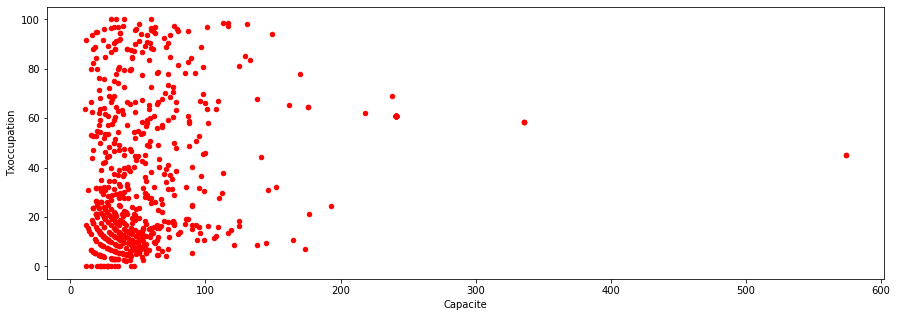

In [ ]:
# Compléter la carte avec un nuage de points

IRISFINAL.plot(figsize =(15,5), kind="scatter", x="Capacite", y= "Txoccupation", color = 'red')

# Exercice autour des pistes cyclables

* Faire la jointure spatiale (pistes cyclables <> IRIS
* Calculer la somme des longueurs de pistes cyclable par IRIS
* Cartographier cet indicateur

In [ ]:
#Observer les données
pistescyclables.head()

,circulation,length,date_de_livraison,bois,couloir_bus,typologie_simple,statut,sens_velo,bidirectionnel,longueur_du_troncon_en_km,voie,arrdt,piste,type_continuite,reseau,position,geometry,longueur
0,NaN,5.955384,2013-12-31,Non,NaN,Bandes cyclables,VOIE 50,CONTRESENS,Non,0.005955,AVENUE FELIX FAURE,15.0,NaN,NaN,NaN,NaN,"LINESTRING (647320.129 6860108.864, 647322.172...",6.0
1,NaN,142.714717,2010-06-10,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.142715,RUE CIVIALE,10.0,NaN,NaN,NaN,NaN,"LINESTRING (654137.796 6863870.485, 654189.364...",143.0
2,NaN,98.520279,2010-12-31,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.098520,RUE D OUESSANT,15.0,NaN,NaN,NaN,NaN,"LINESTRING (648514.230 6861290.908, 648473.072...",99.0
3,NaN,60.405555,2010-12-31,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.060406,RUE BERTIN POIREE,1.0,NaN,NaN,NaN,NaN,"LINESTRING (651935.282 6862296.474, 651940.199...",60.0
4,NaN,167.313331,2013-08-22,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE DE RENCONTRE,CONTRESENS,Non,0.167313,RUE JEAN-JACQUES ROUSSEAU,1.0,NaN,NaN,NaN,NaN,"LINESTRING (651690.927 6862756.652, 651557.929...",167.0


In [ ]:
# Jointure spatiale pistes cyclables <> IRIS

pistescyclablesok = gpd.sjoin(pistescyclables, IRIS)
pistescyclablesok.head(3)

,circulation,length,date_de_livraison,bois,couloir_bus,typologie_simple,statut,sens_velo,bidirectionnel,longueur_du_troncon_en_km,...,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,surface,Longitude,Latitude
0,NaN,5.955384,2013-12-31,Non,NaN,Bandes cyclables,VOIE 50,CONTRESENS,Non,0.005955,...,Javel 6,75115,6006,H,751156006,Paris 15e Arrondissement,75,0.046,2.2852,48.8406
511,NaN,77.487545,2013-12-31,Non,NaN,Bandes cyclables,VOIE 30,CONTRESENS,Non,0.077488,...,Javel 6,75115,6006,H,751156006,Paris 15e Arrondissement,75,0.046,2.2852,48.8406
2778,NaN,107.084926,2019-08-31,Non,NaN,Autres itinéraires cyclables (ex : Aires piéto...,ZONE 30,CONTRESENS,Non,0.107085,...,Javel 6,75115,6006,H,751156006,Paris 15e Arrondissement,75,0.046,2.2852,48.8406


In [ ]:
#Calculer la longueur des pistes cyclables par IRIS et en faire une carte

Longueurpistescyclables  = pistescyclablesok[["nom_iris", "longueur"]].groupby("nom_iris").sum()
Longueurpistescyclables =pd.DataFrame(Longueurpistescyclables)
Longueurpistescyclables.head(5)

,longueur
nom_iris,
Amerique 1,2002.0
Amerique 10,1164.0
Amerique 11,1295.0
Amerique 12,830.0
Amerique 13,959.0


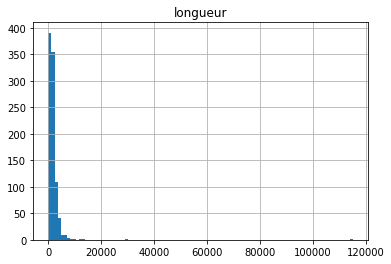

In [ ]:
#On affiche l'histogramme du dataframe précédent
hist = Longueurpistescyclables.hist(bins=100)

In [ ]:
#Vérification somme

total1 = pistescyclablesok['longueur'].sum()
total2 = Longueurpistescyclables['longueur'].sum()

print(total1)
print(total2)

1684530.0
1684530.0


In [ ]:
# Faire la jointure attributaire

IRISfinal = IRIS.merge(Longueurpistescyclables, left_on='nom_iris', right_on='nom_iris')
IRISfinal.head()

,nom_iris,insee_com,iris,typ_iris,code_iris,nom_com,dep,geometry,surface,Longitude,Latitude,longueur
0,Val de Grace 7,75105,1907,H,751051907,Paris 5e Arrondissement,75,"POLYGON ((651827.000 6860330.000, 651871.600 6...",0.123,2.3462,48.8426,2053.0
1,Gros Caillou 7,75107,2807,H,751072807,Paris 7e Arrondissement,75,"POLYGON ((648699.720 6861458.710, 648626.610 6...",0.124,2.2966,48.8546,1675.0
2,Madeleine 3,75108,3103,A,751083103,Paris 8e Arrondissement,75,"POLYGON ((650095.100 6864047.000, 650096.000 6...",0.080,2.3159,48.8734,238.0
3,Roquette 18,75111,4318,H,751114318,Paris 11e Arrondissement,75,"POLYGON ((654660.400 6862417.100, 654717.000 6...",0.051,2.3814,48.8588,4023.0
4,Folie Mericourt 14,75111,4114,H,751114114,Paris 11e Arrondissement,75,"POLYGON ((654009.750 6863582.110, 654007.750 6...",0.035,2.3731,48.8692,1588.0


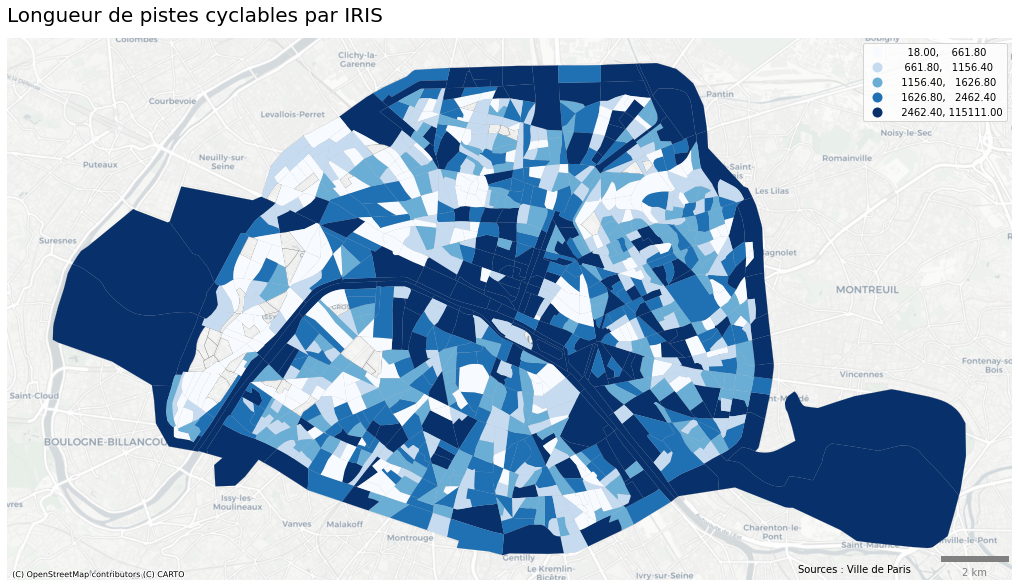

In [ ]:
#Cartographier la capacité des stations de vélibs par IRIS

Carte2, ax = plt.subplots(figsize=(18,16))

IRIS.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.1, color = 'black', zorder = 1)
IRISfinal.to_crs('EPSG:3857').plot(ax=ax, column="longueur", alpha=1, cmap='Blues',scheme='quantiles', categorical=False, legend=True, zorder = 2)
ctx.add_basemap(ax,  source=ctx.providers.CartoDB.Positron)

ax.axis("off")
plt.title('Longueur de pistes cyclables par IRIS', loc='left', fontsize=20)
ax.text(0.90, 0.01, 'Sources : Ville de Paris', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='black', fontsize=10)
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

plt.show()

In [ ]:
# Exo Amenagement cyclables 

amenagementcyclable = pistescyclablesok[(pistescyclablesok["typologie_simple"] == "Bandes cyclables")]

# Exporter les couches dans différents formats

In [ ]:
# Exporter des couches

## En shapefile

IRISFINAL.to_file("IRISbis.shp")

## En GEOJSON

IRISFINAL.to_file("IRISbis.geojson", driver='GeoJSON')

## En Geopackage (pour combiner plusieurs couches)

IRISFINAL.to_file("Paris.gpkg", layer='countries', driver="GPKG")
Velibok.to_file("Paris.gpkg", layer='cities', driver="GPKG")